## This is a first analysis of the data send by Tom
The idea is to do some first exploratory analysis.
Also, the data is transformed and saved in useable formats.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import bisect
from pyproj import Proj  # Package for doing GPS-calculations and Projections
import simplekml   # To export Google Map Files
from scipy.stats import binned_statistic

In [17]:
# Define where to find the files and actually load them:

ibd_file_path = "./Data/CB10k.ibd30.ibd.txt"
coordinate_path = "./Data/CB108.coordinate.txt"

# Load the IBD data
ibd_data = pd.read_csv(ibd_file_path, sep="\t", header=None)
ibd_data.columns = ["Ind1", "HapIndex1", "Ind2", "HapIndex2","Scaffold", "IBDStart", "IBDEnd", "Lod", "IBDlen"]   # Set the column headers

# Load the coordinates
coords = pd.read_csv(coordinate_path, sep="\t")

In [18]:
ibd_data.head(3)

,Ind1,HapIndex1,Ind2,HapIndex2,Scaffold,IBDStart,IBDEnd,Lod,IBDlen
0,CB336,1,CB376,1,Scaffold10040,1140875,1308706,5.23,167832
1,CB336,1,CB376,1,Scaffold10040,1308714,1476150,3.36,167437
2,CB336,1,CB376,1,Scaffold10040,2942385,3176848,3.81,234464


In [19]:
coords.head(3)

,ID,Latitude,Longitude
0,CB001,38.98123,-106.99833
1,CB047,38.98003,-106.99963
2,CB061,38.98498,-107.00957


In [21]:
# start doing some simple summary of the data:
nr_ibd_blocks = len(ibd_data)
nr_inds = len(coords)
print("Total Number of IBD Blocks: %i" % nr_ibd_blocks)
print("Total Number of Individuals: %i" % nr_inds)

Total Number of IBD Blocks: 128049
Total Number of Individuals: 108


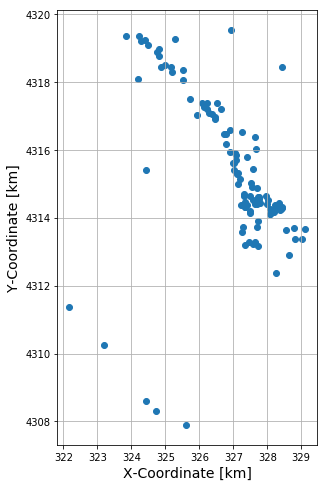

,ID,Latitude,Longitude,Easting,Northing
0,CB001,38.98123,-106.99833,326907.992860,4.316593e+06
1,CB047,38.98003,-106.99963,326792.454302,4.316462e+06
2,CB061,38.98498,-107.00957,325943.505859,4.317031e+06
3,CB063,38.98808,-107.00797,326089.688918,4.317372e+06
4,CB068,38.96090,-106.99268,327348.054704,4.314326e+06


In [60]:
# Convert Individual GPS Coordinates into Meters:
# Add altitude

#Prepare the Longitude/Latidude to Easting/Northing transformer:
my_proj = Proj(proj='utm', zone="13S", ellps='WGS84', units='m') 

# Transform all coordinates:

latloncoords = coords[["Latitude","Longitude"]].values

# Transform to xy Coordinates (in Form Easting, Northing)
xy_coords = np.array([my_proj(latloncoords[i,1], latloncoords[i,0]) for i in xrange(len(latloncoords))])
xy_coords[:10] # Easting,

# Make a Map to plot things nicely:
plt.figure(figsize=(8,8))
plt.scatter(xy_coords[:,0]/1000.0, xy_coords[:,1]/1000.0)
plt.xlabel("X-Coordinate [km]", fontsize=14)
plt.ylabel("Y-Coordinate [km]", fontsize=14)
plt.axes().set_aspect('equal')
plt.grid(True)
plt.show()

# Add Altititude Values (from Shuttle Data)
# Make this later

# Add Northing and Easting [in meters] to the datasets
coords["Easting"] = xy_coords[:,0]
coords["Northing"] =  xy_coords[:,1]

# Maybe cut out outliers
coords.head(5)

In [48]:
# Extract Google Maps File  (.kml) to verify the spatial position
kml = simplekml.Kml()

# First define the Styles (the pins)
style = simplekml.StyleMap()  # Create a style map for highlight style and normal style FOR UNCORRECTED
style.normalstyle.labelstyle.scale = 0
style.normalstyle.iconstyle.icon.href = "http://maps.google.com/mapfiles/kml/pushpin/grn-pushpin.png"
style.highlightstyle.labelstyle.scale = 1
style.highlightstyle.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/pushpin/red-pushpin.png'

print("Creating .kml for %i individuals" % nr_inds)
for i in xrange(nr_inds):
    #if not coords.loc[i, lat_corr_ind]: continue  # Stop if no GPS data    
    lat = coords["Latitude"].iloc[i]
    lon = coords["Longitude"].iloc[i]
    ind_id = coords["ID"].iloc[i]
    
    pnt = kml.newpoint(name=ind_id, coords=[(lon, lat)])   # Could add altitude to lon/lat
    #pnt.description = data[i, comm_ind]
    pnt.stylemap = style
    pnt.altitudemode = 'clamptoground'
    pnt.extrude = 1

kml.save("boechera_samples.kml")
print(".kml successfully generated!")

Creating .kml for 108 individuals
.kml successfully generated!


In [108]:
# Calculate all pairwise Distances for all blocks:

def pw_distance(coords0, coords1):
    '''Calculates the pairwise distance between coords0, coords1'''
    dist=np.linalg.norm(coords0-coords1)
    return dist

pw_dists = np.zeros(nr_ibd_blocks) # Empty Container

# Iterate over all blocks:
for i in xrange(nr_ibd_blocks):
    if i%1000==0:
        print("Doing Pair %i" %i)
    ind1 = ibd_data["Ind1"].iloc[i]
    ind2 = ibd_data["Ind2"].iloc[i]

    row1 = coords[coords["ID"]==ind1]
    row2 = coords[coords["ID"]==ind2]
    
    # Sanity Check (I can find everything only once!)
    assert(len(row1)==1)
    assert(len(row2)==1)
    
    coords1=row1[["Easting","Northing"]].values[0]
    coords2=row2[["Easting","Northing"]].values[0]

    pw_dists[i]=pw_distance(coords1, coords2)

ibd_data["pw_dist"]=pw_dists  # Add the pairwise distance column to 

Doing Pair 0
Doing Pair 1000
Doing Pair 2000
Doing Pair 3000
Doing Pair 4000
Doing Pair 5000
Doing Pair 6000
Doing Pair 7000
Doing Pair 8000
Doing Pair 9000
Doing Pair 10000
Doing Pair 11000
Doing Pair 12000
Doing Pair 13000
Doing Pair 14000
Doing Pair 15000
Doing Pair 16000
Doing Pair 17000
Doing Pair 18000
Doing Pair 19000
Doing Pair 20000
Doing Pair 21000
Doing Pair 22000
Doing Pair 23000
Doing Pair 24000
Doing Pair 25000
Doing Pair 26000
Doing Pair 27000
Doing Pair 28000
Doing Pair 29000
Doing Pair 30000
Doing Pair 31000
Doing Pair 32000
Doing Pair 33000
Doing Pair 34000
Doing Pair 35000
Doing Pair 36000
Doing Pair 37000
Doing Pair 38000
Doing Pair 39000
Doing Pair 40000
Doing Pair 41000
Doing Pair 42000
Doing Pair 43000
Doing Pair 44000
Doing Pair 45000
Doing Pair 46000
Doing Pair 47000
Doing Pair 48000
Doing Pair 49000
Doing Pair 50000
Doing Pair 51000
Doing Pair 52000
Doing Pair 53000
Doing Pair 54000
Doing Pair 55000
Doing Pair 56000
Doing Pair 57000
Doing Pair 58000
Doing Pair

In [118]:
# Save pre-processed Coordinates and IBD-BLocks to .csv files
ibd_data.to_csv('ibd_blocks.csv', index=False)
coords.to_csv('coords.csv', index=False)

ibd_data.head(2)

,Ind1,HapIndex1,Ind2,HapIndex2,Scaffold,IBDStart,IBDEnd,Lod,IBDlen,pw_dist
0,CB336,1,CB376,1,Scaffold10040,1140875,1308706,5.23,167832,141.960302
1,CB336,1,CB376,1,Scaffold10040,1308714,1476150,3.36,167437,141.960302


## Load Pre-Processed Stuff and do Block analysis:

In [204]:
ibd_data = pd.read_csv('ibd_blocks.csv')
coords = pd.read_csv('coords.csv')

ibd_data.head(3)
coords.head(3)


,ID,Latitude,Longitude,Easting,Northing
0,CB001,38.98123,-106.99833,326907.992860,4.316593e+06
1,CB047,38.98003,-106.99963,326792.454302,4.316462e+06
2,CB061,38.98498,-107.00957,325943.505859,4.317031e+06


Analyze 2494 of total 128049 blocks
Analyze 377 of total 128049 blocks
Analyze 65 of total 128049 blocks


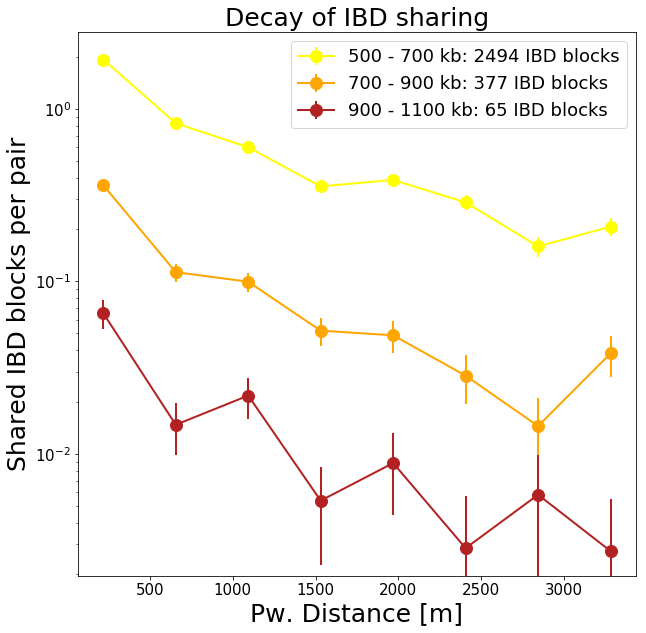

In [205]:
### Plot IBD sharing for different Length Bins


n_bins=8
min_ibd_length=600 # Min Block Length in kb
max_dist = 3500 # Maximum Pairwise Distance [in Meter]

block_categories = [500, 700, 900, 1100] # Block boundaries [in kB]!
coords0 = coords[["Easting","Northing"]].values # Extract Numpy array

def calculate_mean_sharing(min_len, max_len, ibd_data, positions, max_dist, bins=10):
    '''Calculate the mean sharing in block length bins
    positions: nx2 data, n ... nr Individuals
    ibd_data: Pandas Data Table of ibd-block sharing
    
    Return: 
    Mean distance per bin, 
    fraction of sharing in Bin
    Error Fraction (Poisson Assumption)
    '''
    ibd_data_0 = ibd_data[(ibd_data["IBDlen"] > min_len*1000) & (ibd_data["IBDlen"] < max_len*1000)]
    nr_blocks0 = len(ibd_data_0)
    print("Analyze %i of total %i blocks" % (nr_blocks0, len(ibd_data)))
    
    # Do the binning:
    counts, bins = np.histogram(ibd_data_0["pw_dist"], range=[-0.01, max_dist], bins=n_bins)  # @UnusedVariable

    # Find proper normalization factors:
    distance_bins = np.zeros(len(bins) - 1)  # Create bins for every element in List; len(bins)=len(counts)+1
    bins[-1] += 0.000001  # Hack to make sure that the distance exactly matching the max are counted
    #         for i in self.start_list[1:]:  # Calculate distance to the first element in start_list for all elements to get proxy for number of comparisons
    #             dist = torus_distance(i[0], i[1], self.start_list[0][0], self.start_list[0][1], self.gridsize)
    #                 
    #             j = bisect.bisect_right(bins, dist)
    #             if j < len(bins) and j > 0:  # So it actually falls into somewhere
    #                 distance_bins[j - 1] += 1

    
    nr_inds0 = len(positions)

    # Calculate Distance for every possible pair to get proper normalization factor:
    for (x, y) in itertools.combinations(np.arange(nr_inds0), r=2):
        coords1= positions[x,:]
        coords2= positions[y,:]
        dist=pw_distance(coords1, coords2)

        # Add pairwise distance to the right bin:
        j = bisect.bisect_right(bins, dist)
        if j < len(bins) and j > 0:  # So it actually falls into somewhere
            distance_bins[j - 1] += 1

    # distance_mean, _, _ = binned_statistic(ibd_data_0["pw_dist"], ibd_data_0["pw_dist"], bins=n_bins, statistic='mean')  # Calculate mean distances for distance bins
    distance_mean=(bins[1:]+bins[:-1])/2.0

    distance_mean = distance_mean[counts != 0]  # Remove bins with no values / MAYBE UPDATE?
    distance_bins = distance_bins[counts != 0]
    counts = counts[counts != 0]
    distance_mean[distance_mean == 0] = 0.001  # In deme case, to account for possibility of bins with dist=0    

    # Poisson-Error:
    error = np.sqrt(counts)
    ibd_frac = [counts[i] / distance_bins[i] for i in range(0, len(counts))]
    ibd_error = [error[i] / distance_bins[i] for i in range(0, len(counts))]  # STD
    
    return [distance_mean, ibd_frac, ibd_error, nr_blocks0]



### Do the Analysis:
res = []  # Container for the Results

for k in xrange(len(block_categories)-1):
    temp_res = calculate_mean_sharing(block_categories[k],block_categories[k+1], ibd_data, coords0, max_dist)
    res.append(temp_res)


### Plot the results:
plt.figure(figsize=(10,10))
plt.yscale('log')

colors=["Yellow", "Orange", "FireBrick"]
for i in xrange(len(res)):
    distance_mean, ibd_frac, ibd_error, nr_blocks0 = res[i]
    label = "%.0f - %.0f kb: %i IBD blocks" % (block_categories[i], block_categories[i+1], nr_blocks0)
    plt.errorbar(distance_mean, ibd_frac, ibd_error, marker='o', label=label, markersize=12,
                 linewidth=2, color=colors[i])
#plt.semilogy(x_plot, bessel_decay(x_plot, C1, r1), 'r-.', label="Fitted Bessel decay", linewidth=2)  # Plot of exact fit
plt.xlabel('Pw. Distance [m]', fontsize=25)
plt.ylabel('Shared IBD blocks per pair', fontsize=25)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.legend(prop={'size':18})
plt.title("Decay of IBD sharing", fontsize=25)

# Show simga
#plt.annotate(r'$\bar{\sigma}=%.4G \pm %.2G$' % (sigma_estimate1, sigma_std1) , xy=(0.1, 0.12), xycoords='axes fraction', fontsize=30)
plt.show()

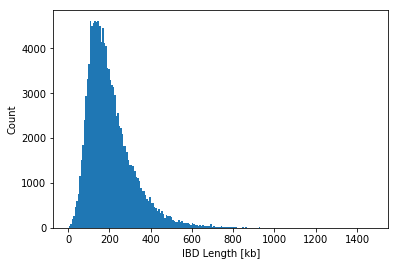

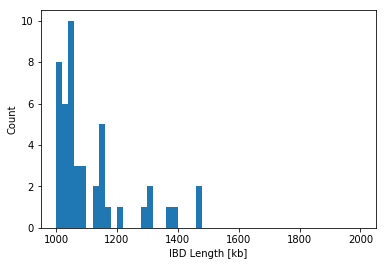

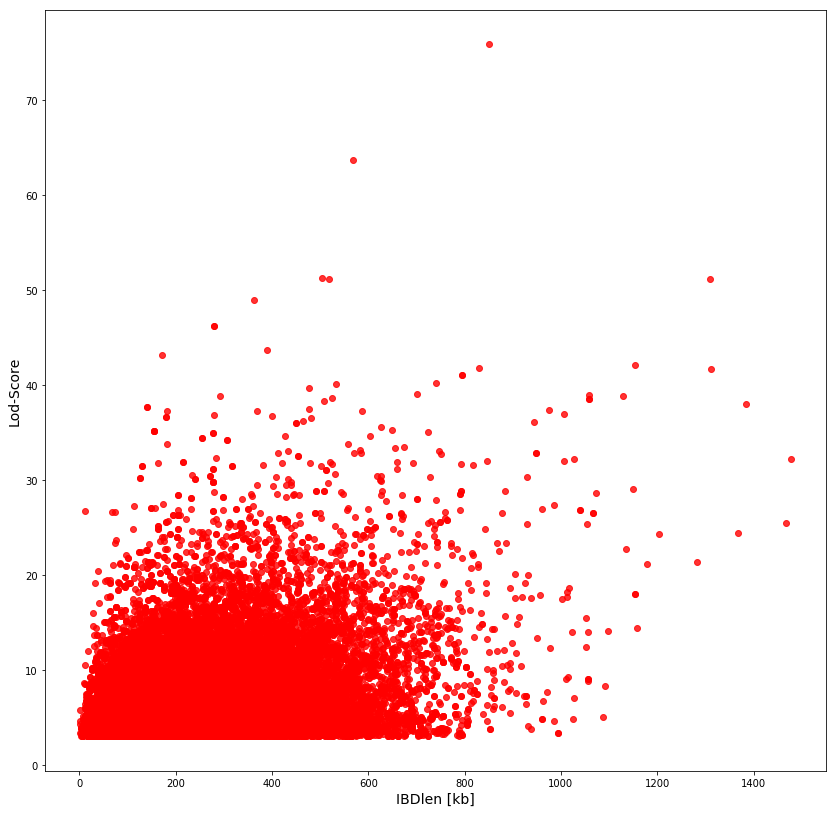

Nr of IBD blocks longer than 1000 kb: 46


In [203]:
# Do Histogram of Block lenthgs:
plt.figure()
plt.hist(ibd_data["IBDlen"]/1000.0, bins=200)
plt.xlabel("IBD Length [kb]")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.hist(ibd_data["IBDlen"]/1000.0, bins=50, range=(1000,2000))
plt.xlabel("IBD Length [kb]")
plt.ylabel("Count")
plt.show()

# Plot IBD block length against LOD score:

plt.figure(figsize=(14,14))
plt.plot(ibd_data["IBDlen"]/1000.0,ibd_data["Lod"],'ro', alpha=0.8)
plt.xlabel("IBDlen [kb]", fontsize=14)
plt.ylabel("Lod-Score", fontsize=14)
plt.show()

threshold=1000 
nr = np.sum(ibd_data["IBDlen"]/1000.0 > threshold)
print("Nr of IBD blocks longer than %i kb: %i" % (threshold, nr))

## Some are 51 stuff:
Area 51: I test code junks.

In [175]:
np.sum((ibd_data["IBDlen"] > 800*1000) & (ibd_data["IBDlen"] < 1000*1000))

120